In [1]:
#Installing the adjustText library
!pip install adjustText

  Created wheel for adjustText: filename=adjustText-0.7.3-cp36-none-any.whl size=7099 sha256=50044ecc78fd470a58716a77206f11c32ce25f5d9997f194fc126f746a53280e
  Stored in directory: /root/.cache/pip/wheels/41/95/74/7d347e136d672f8bc28e937032bc92baf4f80856763a7e7b72
Successfully built adjustText


In [2]:
# Data from here:
# https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from adjustText import adjust_text
from matplotlib.ticker import ScalarFormatter

# READ CUMULATIVE TABLE
covid_cumulative = pd.read_excel("covid_a_master_cumulative_table.xlsx")

## FILTER THE LAST DAY OF THE RESULTS AND PICK THE TOP N IN # OF DEATHS

In [3]:
# This part is necessary instead of simply ['Date'].max() because some countries do not report on certain days (e.g. Spain on Sundays) -- FIXED BUG
last_day_per_country = covid_cumulative.groupby(by=['Countries'])['Date'].max() # type(last_day_per_country) is pandas.Series
last_day_per_country = last_day_per_country.to_frame() # We convert it to pandas.DataFrame
last_day_per_country.reset_index(inplace=True) # And reset the index so that we can further join on 'Countries'

In [4]:
# N: HOW MANY TOP COUNTRIES YOU WANT TO PICK IN TERMS OF # OF DEATHS
N = 20
last_day = pd.merge(covid_cumulative, last_day_per_country, how='inner', left_on = ['Countries', 'Date'], right_on = ['Countries', 'Date'])
last_day = last_day.sort_values('Deaths', ascending=False)
top_countries = last_day[:N]['Countries'].tolist()

## FURTHER FILTER THE TOP N COUNTRIES WITH >K DEATHS


In [5]:
# K: HOW MANY DEATHS YOU CONSIDER THE DAY 0
#Considering 10 deaths to be day 0 as per the instructions
K = 10
covid_top_countries = covid_cumulative[covid_cumulative.Countries.isin(top_countries)]
covid_top_countries = covid_top_countries[covid_top_countries['Deaths'] > K]

In [6]:
# FIND THE DATE THAT THE FIRST K DEATHS WERE IDENTIFIED
day_0_for_every_country = covid_top_countries.groupby(by=['Countries']).min()
day_0_for_every_country = day_0_for_every_country['Date']

In [7]:
# MERGE THE TWO TO GET THE DAY_0 IN THE df, AND CALCULATE THE DAYS_FROM_0
covid_top_countries = covid_top_countries.merge(day_0_for_every_country, how='inner', on='Countries')
covid_top_countries.rename(columns = {'Date_y': 'Day_0'}, inplace = True)
covid_top_countries['Days_from_0'] = (covid_top_countries['Date_x'] - covid_top_countries['Day_0']).dt.days

In [8]:
#Adding the Mortality rate per 1M column to the covid_top_countries dataframe
covid_top_countries['Mortality_rate_per_1m'] = covid_top_countries['Deaths']/covid_top_countries['Population']*1000000

### CREATE THE MAX_DEATHS DF TO USE IT IN LABELING THE GRAPHS

In [9]:
#For labelling in the graph
max_deaths = covid_top_countries.groupby(by=['Countries']).max()
max_deaths['Case_fatality_rate'] = max_deaths['Deaths']/max_deaths['Cases']*100
max_deaths.sort_values('Deaths', ascending=False)
max_deaths['Infection_rate_per_1m'] = max_deaths['Cases']/max_deaths['Population']*1000000
max_deaths['Mortality_rate_per_1m'] = max_deaths['Deaths']/max_deaths['Population']*1000000
max_deaths.drop('Unnamed: 0', axis = 1, inplace = True)
max_deaths.to_excel('covid_b_max_deaths.xlsx')

In [10]:
#Sorting the data countries wise according to mortality rate per 1M
covid_top_countries.index.name = None
max_slope = covid_top_countries.groupby(by=['Countries']).max()
max_slope = max_slope.sort_values('Mortality_rate_per_1m', ascending=False)
max_slope['Countries'] = max_slope.index

data_1_5 = covid_top_countries[covid_top_countries.Countries.isin(max_slope[:5]['Countries'].tolist())]
countries_1_5 = max_slope[:5]['Countries'].tolist()
data_6_10 = covid_top_countries[covid_top_countries.Countries.isin(max_slope[5:10]['Countries'].tolist())]
countries_6_10 = max_slope[5:10]['Countries'].tolist()
data_11_15 = covid_top_countries[covid_top_countries.Countries.isin(max_slope[10:15]['Countries'].tolist())]
countries_11_15 = max_slope[10:15]['Countries'].tolist()
data_16_20 = covid_top_countries[covid_top_countries.Countries.isin(max_slope[15:20]['Countries'].tolist())]
countries_16_20 = max_slope[15:20]['Countries'].tolist()
max_slope

,Unnamed: 0,Cases,Deaths,Date_x,Population,Continent,Day_0,Days_from_0,Mortality_rate_per_1m,Countries
Countries,,,,,,,,,,
Peru,38854,613378,28124,2020-08-27,3.251046e+07,America,2020-03-28,152,865.075372,Peru
Belgium,38721,82936,9879,2020-08-27,1.145552e+07,Europe,2020-03-15,165,862.379086,Belgium
UK,38897,328846,41465,2020-08-27,6.664711e+07,Europe,2020-03-15,165,622.157491,UK
Spain,38672,419849,28971,2020-08-26,4.693706e+07,Europe,2020-03-10,169,617.230819,Spain
Italy,38801,262540,35458,2020-08-27,6.035955e+07,Europe,2020-02-26,183,587.446433,Italy
Chile,38743,402365,10990,2020-08-27,1.895204e+07,America,2020-04-01,148,579.884957,Chile
Brazil,38730,3717156,117665,2020-08-27,2.110495e+08,America,2020-03-21,159,557.523185,Brazil
USA,38898,5821876,179714,2020-08-27,3.290649e+08,America,2020-03-05,175,546.135400,USA
Mexico,38828,573888,62076,2020-08-27,1.275755e+08,America,2020-03-28,152,486.582344,Mexico


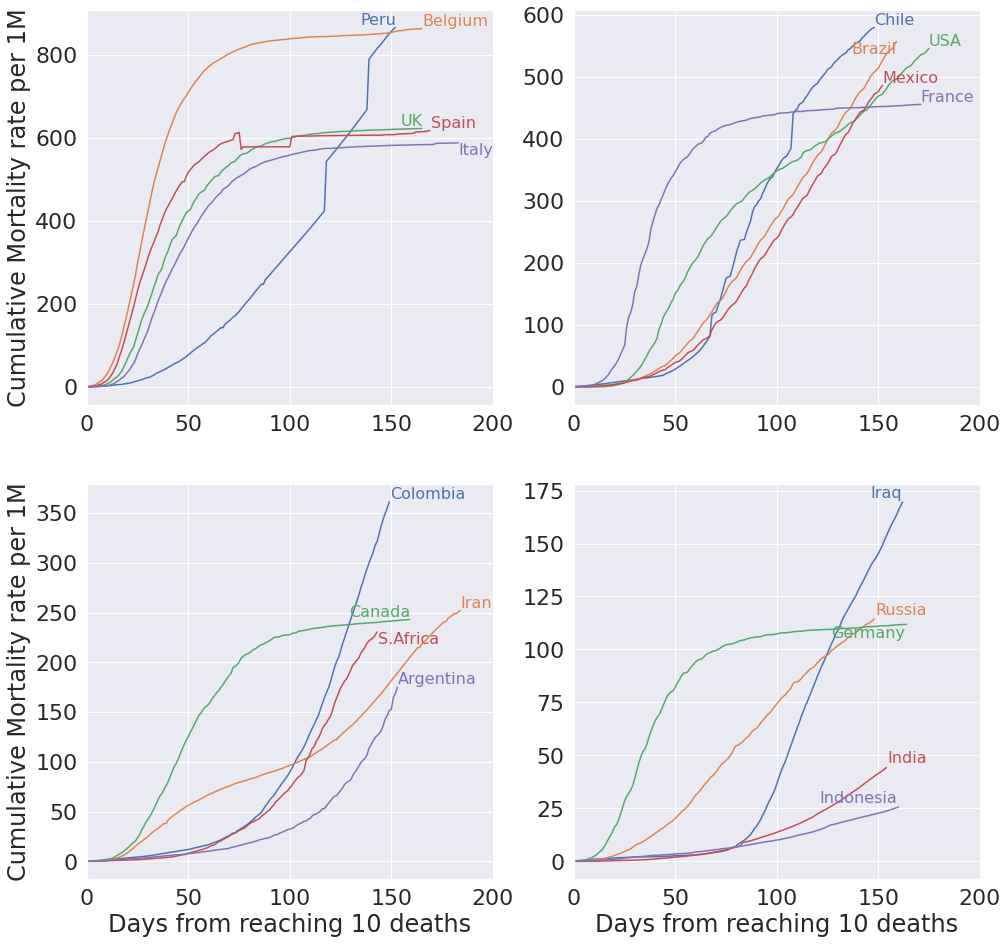

In [11]:
#Plotting the graph for infection rate per 1M
sns.set(rc={'figure.figsize':(16,16)}, font_scale = 2)
fig, axes = plt.subplots(2, 2)

sns.lineplot(x="Days_from_0", y="Mortality_rate_per_1m", hue="Countries", data=data_1_5, markers=True, hue_order=countries_1_5, legend=False, ax=axes[0, 0])
texts = [axes[0, 0].text(max_deaths.loc[str(country)]['Days_from_0'], max_deaths.loc[str(country)]['Mortality_rate_per_1m'], str(country), fontsize=16, color=axes[0, 0].get_lines()[countries_1_5.index(country)].get_c(), ha = 'left', va = 'center') for country in countries_1_5]
adjust_text(texts)
axes[0, 0].set_ylabel("Cumulative Mortality rate per 1M",fontsize=24)

sns.lineplot(x="Days_from_0", y="Mortality_rate_per_1m", hue="Countries", data=data_6_10, markers=True, hue_order=countries_6_10, legend=False, ax=axes[0, 1])
texts = [axes[0, 1].text(max_deaths.loc[str(country)]['Days_from_0'], max_deaths.loc[str(country)]['Mortality_rate_per_1m'], str(country), fontsize=16, color=axes[0, 1].get_lines()[countries_6_10.index(country)].get_c(), ha = 'left', va = 'top') for country in countries_6_10]
adjust_text(texts)

sns.lineplot(x="Days_from_0", y="Mortality_rate_per_1m", hue="Countries", data=data_11_15, markers=True, hue_order=countries_11_15, legend=False, ax=axes[1, 0])
texts = [axes[1, 0].text(max_deaths.loc[str(country)]['Days_from_0'], max_deaths.loc[str(country)]['Mortality_rate_per_1m'], str(country), fontsize=16, color=axes[1, 0].get_lines()[countries_11_15.index(country)].get_c(), ha = 'left', va = 'center') for country in countries_11_15]
adjust_text(texts)
axes[1, 0].set_ylabel("Cumulative Mortality rate per 1M",fontsize=24)
axes[1, 0].set_xlabel("Days from reaching 10 deaths",fontsize=24)

sns.lineplot(x="Days_from_0", y="Mortality_rate_per_1m", hue="Countries", data=data_16_20, markers=True, hue_order=countries_16_20, legend=False, ax=axes[1, 1])
texts = [axes[1, 1].text(max_deaths.loc[str(country)]['Days_from_0'], max_deaths.loc[str(country)]['Mortality_rate_per_1m'], str(country), fontsize=16, color=axes[1, 1].get_lines()[countries_16_20.index(country)].get_c(), ha = 'left', va = 'center') for country in countries_16_20]
adjust_text(texts)
axes[1, 1].set_xlabel("Days from reaching 10 deaths",fontsize=24)

axes[0, 1].set_ylabel("",fontsize=24)
axes[1, 1].set_ylabel("",fontsize=24)
axes[0, 0].set_xlabel("",fontsize=24)
axes[0, 1].set_xlabel("",fontsize=24)
axes[0, 1].set_xlim([0, 200])
axes[1, 1].set_xlim([0, 200])
axes[0, 0].set_xlim([0, 200])
axes[1, 0].set_xlim([0, 200])
# axes[0, 0].set_yscale('log')
# axes[0, 1].set_yscale('log')
# axes[1, 0].set_yscale('log')
# axes[1, 1].set_yscale('log')

plt.savefig('Fig_2_2_Choudhary_Shreyas.png')